# EDA

In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.feature_selection import RFE
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
terry_df = pd.read_csv('../data/terry_clean.csv')

In [3]:
terry_df.head()

,date,subject_id,subject_age,subject_race,subject_gender,stop_resolution,weapon_type,officer_id,officer_age,officer_race,officer_gender,officer_squad,initial_call_type,call_type,arrest,frisk,precinct,sector,beat
0,2018-04-03,-1,26 - 35,White,Male,Field Contact,None,7662,30,White,M,WEST PCT 1ST W - KING/QUEEN,NaN,NaN,0,0.0,NaN,NaN,NaN
1,2018-04-05,-1,26 - 35,American Indian or Alaska Native,Male,Field Contact,None,7770,31,Asian,M,EAST PCT 3RD W - CHARLIE,NaN,NaN,0,0.0,NaN,NaN,NaN
2,2018-04-06,-1,26 - 35,White,Male,Field Contact,None,8377,35,White,M,EAST PCT 2ND W - CHARLIE,NaN,NaN,0,0.0,NaN,NaN,NaN
3,2018-04-09,-1,26 - 35,White,Male,Field Contact,None,8434,37,White,M,WEST PCT 1ST W - DAVID/MARY,NaN,NaN,0,0.0,NaN,NaN,NaN
4,2018-04-06,-1,26 - 35,Black or African American,Female,Field Contact,None,8359,26,White,M,EAST PCT 3RD W - E/G RELIEF,NaN,NaN,0,0.0,NaN,NaN,NaN


In [4]:
terry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42024 entries, 0 to 42023
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               42024 non-null  object 
 1   subject_id         42024 non-null  int64  
 2   subject_age        42024 non-null  object 
 3   subject_race       42024 non-null  object 
 4   subject_gender     42024 non-null  object 
 5   stop_resolution    42024 non-null  object 
 6   weapon_type        33922 non-null  object 
 7   officer_id         42024 non-null  int64  
 8   officer_age        42024 non-null  int64  
 9   officer_race       42024 non-null  object 
 10  officer_gender     42024 non-null  object 
 11  officer_squad      41495 non-null  object 
 12  initial_call_type  29581 non-null  object 
 13  call_type          29581 non-null  object 
 14  arrest             42024 non-null  int64  
 15  frisk              41634 non-null  float64
 16  precinct           328

In [11]:
# chaning datatypes of columns
terry_df = terry_df.astype({'date':'datetime64', 'subject_age': 'category',
                            'subject_race':'category', 'subject_gender':'category',
                            'stop_resolution': 'category','weapon_type':'category',
                             'officer_race': 'category', 'officer_gender':'category',
                            'arrest':'int32', 'frisk':'float',
                            'precinct':'category', 'sector':'category', 'beat': 'category'})

# creating a 'count' column so that counting categories is easier
terry_df['count'] = 1

In [12]:
terry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42024 entries, 0 to 42023
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               42024 non-null  datetime64[ns]
 1   subject_id         42024 non-null  int64         
 2   subject_age        42024 non-null  category      
 3   subject_race       42024 non-null  category      
 4   subject_gender     42024 non-null  category      
 5   stop_resolution    42024 non-null  category      
 6   weapon_type        33922 non-null  category      
 7   officer_id         42024 non-null  int64         
 8   officer_age        42024 non-null  int64         
 9   officer_race       42024 non-null  category      
 10  officer_gender     42024 non-null  category      
 11  officer_squad      41495 non-null  object        
 12  initial_call_type  29581 non-null  object        
 13  call_type          29581 non-null  object        
 14  arrest

## Which Race is stopped the most?

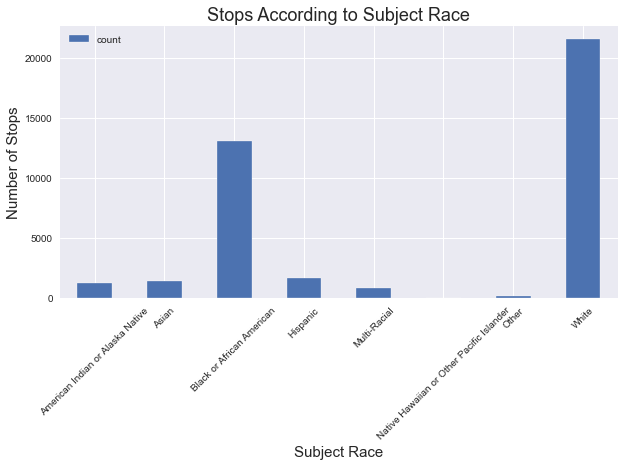

In [41]:
# creating a subset of data to answer questions
sub_race_df = terry_df[['subject_race', 'count']]
sub_race_df = sub_race_df.groupby('subject_race').count()

# eliminating unknown subject_race values
sub_race_df = sub_race_df[sub_race_df.index != 'Unknown']

sub_race_df

ax = sub_race_df.plot(kind = 'bar', figsize=(10,5))
plt.style.use('seaborn')
plt.title('Stops According to Subject Race',
         fontsize=18)
plt.xlabel('Subject Race', fontsize=15)
plt.ylabel('Number of Stops', fontsize=15)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis= 'y')
plt.show()

***
## What are the races of officers who perform stops?

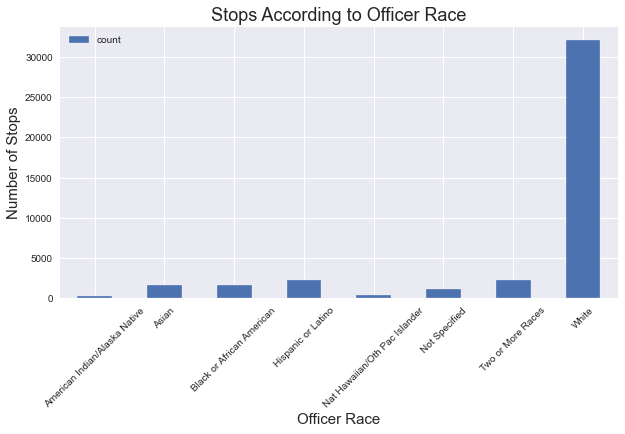

In [42]:
# creating a subset of data to answer questions
off_race_df = terry_df[['officer_race', 'count']]
off_race_df = off_race_df.groupby('officer_race').count()

ax = off_race_df.plot(kind = 'bar', figsize=(10,5))
plt.style.use('seaborn')
plt.title('Stops According to Officer Race',
         fontsize=18)
plt.xlabel('Officer Race', fontsize=15)
plt.ylabel('Number of Stops', fontsize=15)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis= 'y')
plt.show()

***
## Is there a difference in ages across races?

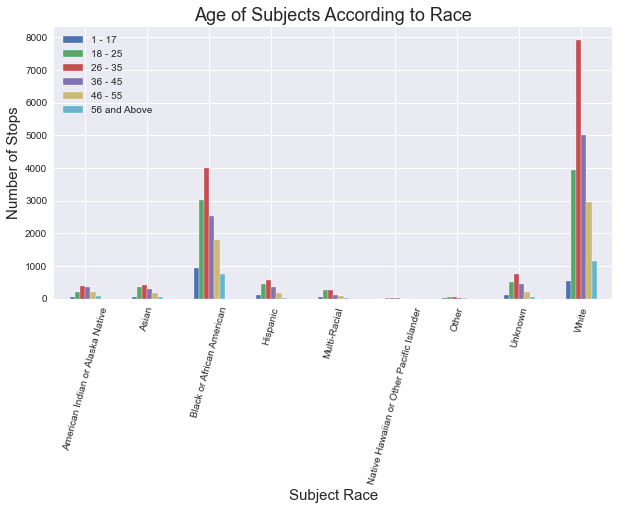

In [55]:
sub_race = terry_df[['subject_race','subject_age','count']]
sub_race = sub_race.groupby(['subject_race', 'subject_age']).count().unstack(level = 'subject_age')

sub_race.plot(kind = 'bar',  figsize=(10,5))
plt.style.use('seaborn')
plt.title('Age of Subjects According to Race',
         fontsize=18)
plt.xlabel('Subject Race', fontsize=15)
plt.ylabel('Number of Stops', fontsize=15)
plt.xticks(rotation=75)
plt.ticklabel_format(style='plain', axis= 'y')
plt.legend(labels = list(sub_race.columns.get_level_values(1)))
plt.show()